<a href="https://colab.research.google.com/github/zhanglab-aim/ucla-automl-workshop/blob/main/UCLA_AutoML_workshop_Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 2. AutoML and Model Explanation


- introduction of reinforcement learning
- apply NAS to automate CNN tuning
- interpret model and sequence motifs

# 0.Software Installation

In [1]:
#%load_ext tensorboard

In [2]:
%pip install -q pytorch-lightning==1.6.5 torchmetrics==0.11.0 expecttest hypothesis amber-automl==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.2/402.2 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 KB 4.5 MB/s eta 0:00:00


In [3]:
#!git clone --quiet https://github.com/zj-zhang/AMBER.git
#!cd AMBER; python setup.py -q develop

In [4]:
!amber-cli config -b pytorch
!amber-cli -v

Setting the default backend to "pytorch".


 █████╗ ███╗   ███╗██████╗ ███████╗██████╗ 
██╔══██╗████╗ ████║██╔══██╗██╔════╝██╔══██╗
███████║██╔████╔██║██████╔╝█████╗  ██████╔╝
██╔══██║██║╚██╔╝██║██╔══██╗██╔══╝  ██╔══██╗
██║  ██║██║ ╚═╝ ██║██████╔╝███████╗██║  ██║
╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚══════╝╚═╝  ╚═╝

Automated Modeling of Biological Evidence-based Research
Version 0.1.5


In [5]:
# download data file
! if [ ! -f "genomic_data.npz" ]; then wget https://raw.githubusercontent.com/zhanglab-aim/ucla-automl-workshop/main/assets/genomic_data.npz ; else echo "Found downloaded data" ; fi

--2023-01-26 04:12:50--  https://raw.githubusercontent.com/zhanglab-aim/ucla-automl-workshop/main/assets/genomic_data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32020490 (31M) [application/octet-stream]
Saving to: ‘genomic_data.npz’

genomic_data.npz    100%[===================>]  30.54M  --.-KB/s    in 0.1s    

2023-01-26 04:12:52 (239 MB/s) - ‘genomic_data.npz’ saved [32020490/32020490]



In [6]:
# reproducibility
import os
import torch
import tensorflow as tf
import numpy as np
import random

# ref: https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
    tf.get_logger().setLevel('ERROR')
    np.random.seed(seed)
    random.seed(seed)
    ## tensorflow
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    ## pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(777)

Random seed set as 777


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

with np.load('genomic_data.npz') as store:
    x = store['x']
    y = store['y']
print(f"examine data shape: x={x.shape}, y={y.shape}")
x_trainvalid, x_test, y_trainvalid, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
x_train, x_valid, y_train, y_valid = train_test_split(x_trainvalid, y_trainvalid, test_size=0.1, random_state=111)
print(f"after split, train={x_train.shape}, {y_train.shape}; valid={x_valid.shape}, {y_valid.shape}; test={x_test.shape}, {y_test.shape}")

examine data shape: x=(5000, 200, 4), y=(5000, 1)
after split, train=(3600, 200, 4), (3600, 1); valid=(400, 200, 4), (400, 1); test=(1000, 200, 4), (1000, 1)


# 1.Define a Framework-agnostic CNN Model Space

In [8]:
from amber import architect
from amber.backend import Operation

In [9]:
model_space = architect.ModelSpace.from_dict([
    # conv1
    [
        Operation('Conv1d', filters=32, kernel_size=7, activation='relu'), Operation('Conv1d', filters=32, kernel_size=13, activation='relu'), Operation('Conv1d', filters=32, kernel_size=3, activation='relu'), 
        Operation('Conv1d', filters=32, kernel_size=7, activation='tanh'), Operation('Conv1d', filters=32, kernel_size=13, activation='tanh'), Operation('Conv1d', filters=32, kernel_size=3, activation='tanh'), 
    ],
    # pool
    [Operation('Maxpool1d', pool_size=4), Operation('Avgpool1d', pool_size=4), Operation('Identity')],
    # conv2
    [
        Operation('Conv1d', filters=64, kernel_size=7, activation='relu'), Operation('Conv1d', filters=64, kernel_size=13, activation='relu'), Operation('Conv1d', filters=64, kernel_size=3, activation='relu'), 
        Operation('Conv1d', filters=64, kernel_size=7, activation='tanh'), Operation('Conv1d', filters=64, kernel_size=13, activation='tanh'), Operation('Conv1d', filters=64, kernel_size=3, activation='tanh'), 
        Operation('Identity')
    ],
    # flatten
    [Operation('Flatten'), Operation('GlobalAveragePooling1D'), Operation('GlobalMaxPooling1D')],
])
print(model_space)

StateSpace with 4 layers and 378 total combinations


In [10]:
input_op = Operation('Input', shape=(200,4))
output_op = Operation('Dense', units=1, activation='sigmoid')

# 2.Building CNN from Model Space

In [11]:
from amber import modeler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
model_builder = modeler.sequential.SequentialModelBuilder(
    inputs_op=input_op, 
    output_op=output_op,
    model_space=model_space,
    model_compile_dict=dict(
        optimizer='adam', 
        loss='binary_crossentropy')
)

In [13]:
arc = [0, 0, 6, 1]
model = model_builder(arc)
model.summary()

Sequential(
  (layers): ModuleList(
    (0): PermuteLayer()
    (1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(7,), stride=(1,))
      (1): ReLU()
    )
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Identity()
    (4): GlobalAveragePooling1DLayer()
    (5): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (criterion): BCELoss()
)


In [14]:
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=64, epochs=5, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

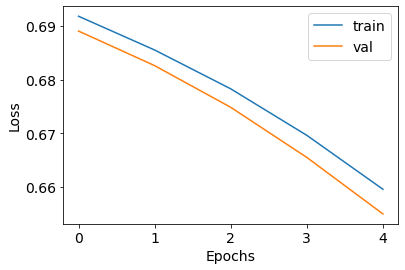

In [15]:
plt.plot(hist.history['train_loss'] if 'train_loss' in hist.history else hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 3.Automated Search of Model Space

In [16]:
# define a search algorithm
controller = architect.GeneralController(model_space=model_space)

In [17]:
# action=integers
# probs=selection probabilities
controller.get_action()

(array([4, 1, 0, 2], dtype=int32),
 [array([[0.16665466, 0.16665043, 0.166673  , 0.1666605 , 0.16669773,
          0.16666366]], dtype=float32),
  array([[0.33329216, 0.33331555, 0.33339226]], dtype=float32),
  array([[0.14286055, 0.14285785, 0.14282915, 0.14282627, 0.14285736,
          0.14287995, 0.14288886]], dtype=float32),
  array([[0.33334982, 0.33333722, 0.33331293]], dtype=float32)])

In [18]:
reward_fn = architect.reward.LossAucReward(method='auroc')
manager = architect.GeneralManager(
    train_data=(x_train, y_train),
    validation_data=(x_valid, y_valid),
    model_fn=model_builder,
    reward_fn=reward_fn,
    epochs=5,
    working_dir="./amber_out"
)
search_env = architect.ControllerTrainEnvironment(
    controller=controller,
    manager=manager,
    time_budget='00:05:00',
    initial_buffering_queue=5,  # start searching after this number of iters
    early_stop_patience=5,      # stop searching if reward not increased by this number of iters
    working_dir="./amber_out",
    verbose=False
)

2023-01-26 04:13:20,718 - AMBER - INFO -
 working directory: /content/amber_out
INFO:AMBER:working directory: /content/amber_out
2023-01-26 04:13:20,721 - AMBER - INFO -
 time budget set to: 00:05:00
INFO:AMBER:time budget set to: 00:05:00


2023-01-26 04:13:25,048 - AMBER - INFO -
 Iter 0, this reward: 2.385, best reward: 2.385, used time: 1.44 %
INFO:AMBER:Iter 0, this reward: 2.385, best reward: 2.385, used time: 1.44 %
2023-01-26 04:13:28,956 - AMBER - INFO -
 Iter 1, this reward: 2.687, best reward: 2.687, used time: 2.74 %
INFO:AMBER:Iter 1, this reward: 2.687, best reward: 2.687, used time: 2.74 %
2023-01-26 04:13:32,806 - AMBER - INFO -
 Iter 2, this reward: 2.180, best reward: 2.687, used time: 4.02 %
INFO:AMBER:Iter 2, this reward: 2.180, best reward: 2.687, used time: 4.02 %
2023-01-26 04:13:36,349 - AMBER - INFO -
 Iter 3, this reward: 2.467, best reward: 2.687, used time: 5.21 %
INFO:AMBER:Iter 3, this reward: 2.467, best reward: 2.687, used time: 5.21 %
2023-01-26 04:13:40,708 - AMBER - INFO -
 Iter 4, this reward: 2.654, best reward: 2.687, used time: 6.66 %
INFO:AMBER:Iter 4, this reward: 2.654, best reward: 2.687, used time: 6.66 %
2023-01-26 04:13:45,189 - AMBER - INFO -
 Iter 5, this reward: 2.701, best 

[0, 0, 0, 2]

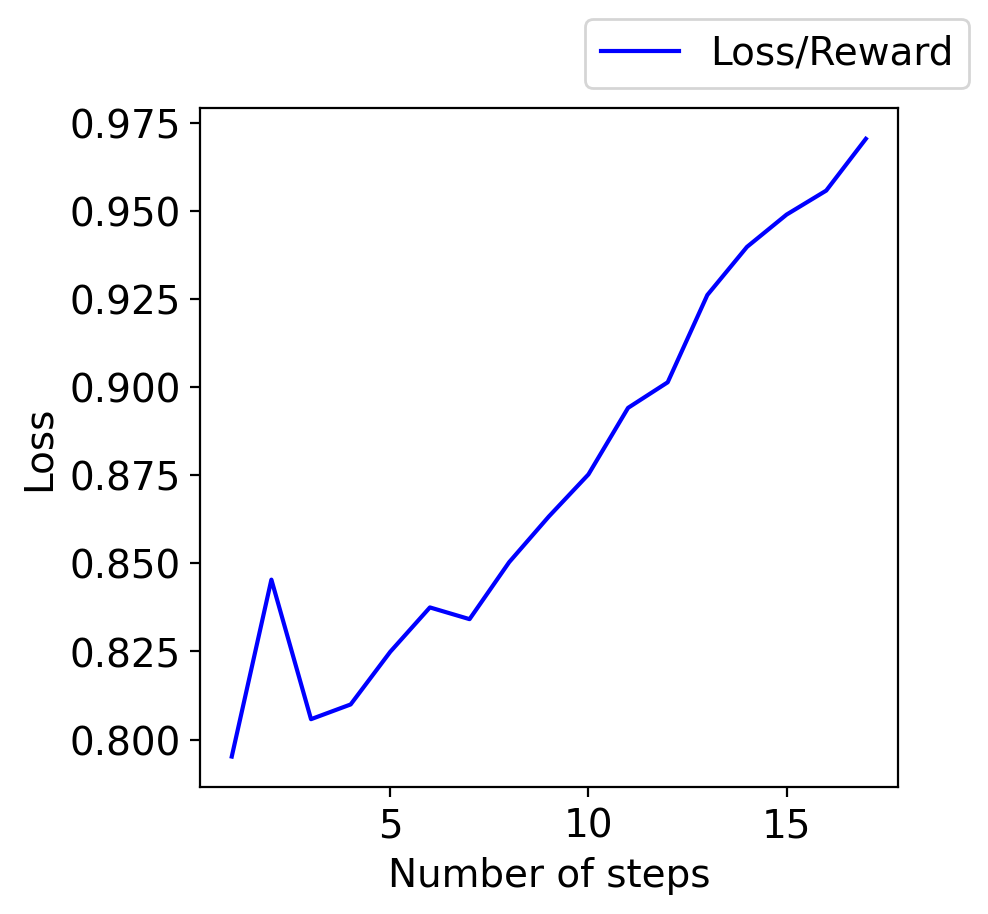

In [19]:
search_env.train()

# 4.Understanding AutoML/NAS Principles


['./amber_out/weight_at_layer_0.png', './amber_out/weight_at_layer_1.png', './amber_out/weight_at_layer_2.png', './amber_out/weight_at_layer_3.png']


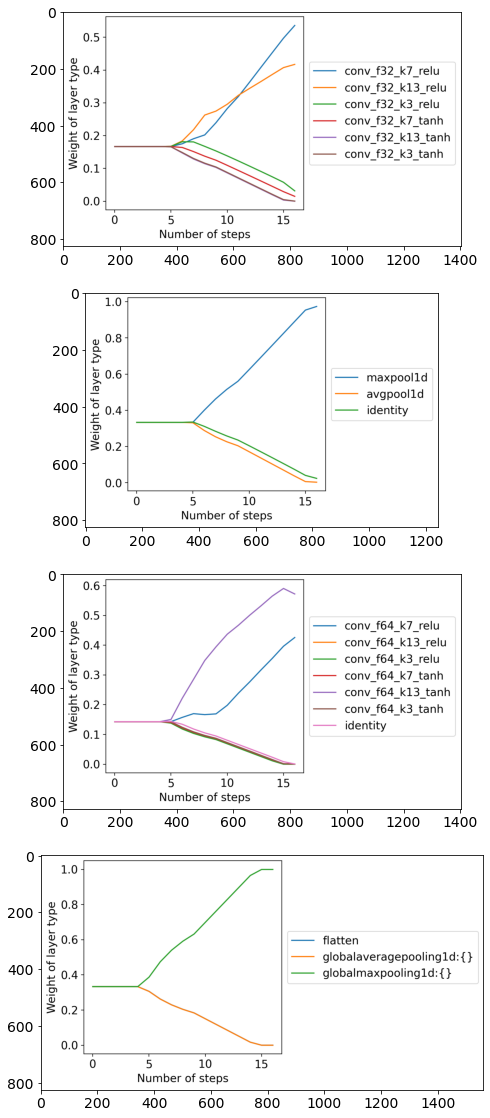

In [20]:
# visualizations
import os
import matplotlib.image as mpimg

plt.figure(figsize=(25,25))
columns = 1
wd = "./amber_out"
images = [os.path.join(wd,x) for x in sorted([x for x in os.listdir(wd) \
                                                            if x.startswith("weight") and x.endswith("png")])]
print(images)
images = [mpimg.imread(_) for _ in images]
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)


# 5.In-Sillico Mutagenesis for Model Explanation

In [21]:
# read in history
import amber
amb_hist = amber.utils.io.read_history("./amber_out/train_history.csv", metric_name_dict={'auc':1})
amb_hist.sort_values('auc', ascending=False).head(5)

read 1 history files, total 51 lines 


,ID,L1,L2,L3,L4,dir,auc
12,12,2,2,4,2,./amber_out,0.999375
10,10,1,2,6,2,./amber_out,0.997725
40,40,1,0,0,2,./amber_out,0.989249
46,46,1,0,0,2,./amber_out,0.988524
15,15,1,0,0,2,./amber_out,0.986874


In [22]:
bestarc = amb_hist.sort_values('auc', ascending=False).iloc[0][['L1', 'L2', 'L3', 'L4']].to_list()
trial_id = amb_hist.sort_values('auc', ascending=False).iloc[0]['ID']
bestmodel = model_builder(bestarc)
if amber.backend.mod_name == 'pytorch':
    bestmodel = bestmodel.load(f"./amber_out/weights/trial_{trial_id}/bestmodel.h5")
else:
    # keras model load is not supported; use load_weights instead
    bestmodel.load_weights(f"./amber_out/weights/trial_{trial_id}/bestmodel.h5")

In [23]:
# confirm the model weights are reloaded
reward_fn(bestmodel, (x_valid, y_valid))

(0.9993749374937493, [0.9993749374937493], {'knowledge': 0})

In [24]:
def in_sillico_mutagenesis(model, input):
    score = np.zeros(input.shape)
    old_pred = model.predict(input[np.newaxis, :]).flatten()
    print("input pred", old_pred)
    for i in range(len(input)):
        for j in range(len(input[i])):
            input_ = input.copy()
            # first, set this nucleotide to 0
            input_[i] = 0
            # then, change the j-th to one-hot encoded
            input_[i, j] = 1
            # insert a new axis for batch dim
            input_ = input_[np.newaxis, :]
            # get importance by taking difference
            new_pred = model.predict(input_).flatten()
            score[i,j] = old_pred - new_pred
    return score.T

In [25]:
# select a target sequence (positive labelled)
target_idx = 4
print("confirm this is a positive labelled sequence", y_valid[target_idx])
scores = in_sillico_mutagenesis(model=bestmodel, input=x_valid[target_idx])

confirm this is a positive labelled sequence [1]
input pred [0.9932289]


Text(0.5, -7.0, 'Position')

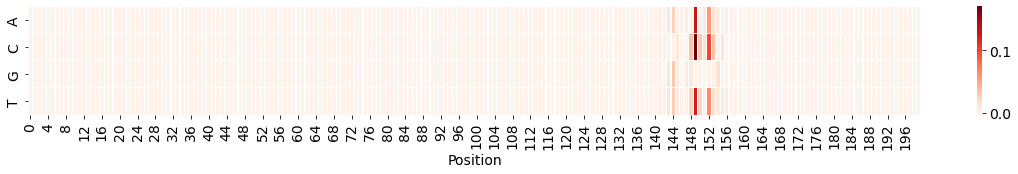

In [26]:
# visualization
fig, ax = plt.subplots(1,1, figsize=(20, 2))
sns.heatmap(scores, ax=ax, cmap='Reds', linewidths=0.1, linecolor='white')
ax.set_yticklabels(['A', 'C', 'G', 'T'])
ax.set_xlabel('Position')

149 [1 2 3 1 0 0 0 2 0 2 0 3 2 1 0 3 0 0 2 2 2 3 3 0 3 1 1 1 1 3 2 2 3 3 2 3 3
 3 1 2 1 3 3 1 0 0 1 0 2 2 0 3 0 3 0 3 0 2 0 3 0 3 1 1 0 3 1 2 3 3 0 1 2 2
 3 0 2 0 2 3 2 2 1 3 0 3 2 0 2 0 2 3 0 1 0 1 1 3 3 1 0 0 0 0 0 2 3 1 3 0 3
 0 0 0 3 1 2 1 0 1 0 0 0 1 3 2 3 0 0 3 1 1 0 3 3 2 1 1 0 3 2 2 0 1 1 0 0 1
 0 2 2 2 2 2 1 2 2 3 2 3 0 1 0 0 3 3 0 0 3 1 0 3 1 1 1 0 0 3 3 1 3 1 3 2 2
 2 3 3 2 0 0 1 3 3 2 0 1 0 2 1]
TGGACCAACAGGGGGCGGTG


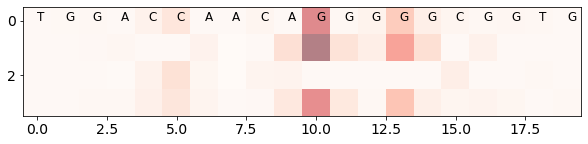

In [27]:
# inspect the DNA by converting matrix to sequence
reverse_lookup = {
    0: 'A', 
    1: 'C', 
    2: 'G', 
    3: 'T'
}

focus = np.argmax(scores.mean(axis=0))
id = np.where(x_valid[target_idx] == 1)[1]
print(focus, id)
seq = [reverse_lookup[i] for i in id]
focus_region = seq[(focus-10):(focus+10)]

plt.figure(figsize=(10, 2))
plt.imshow(scores[:, (focus-10):(focus+10)], cmap='Reds', aspect="auto", interpolation='nearest', alpha=0.5)
for i, word in enumerate(focus_region):
    plt.text(i, 0, word, fontsize=12)

print(f''.join(focus_region))

**Compare to CTCF_known1 motif (ground truth)**

<img src="https://raw.githubusercontent.com/zhanglab-aim/ucla-automl-workshop/main/assets/CTCF_known1_MA0139.1.svg" alt="CTCF_known1 motif" style="height: 300px;"/>


# 6.Extended Practices



6.1 Write a Python function to assess the feature importance for all positive-labelled test sequences. 
*(hint: re-use the code we've developed for a single test sequence).*

6.2 Visualize the feature importance for some negative-labelled test sequences. How do they compare to positive-labelled sequences, and why?

6.3 Explore and implement other model space for AMBER. Can you prune the model space for more efficient search?

6.4 Explore other metrics (e.g. negative loss, accuracy) as the reward to maximize during AMBER model search.

6.5 Explore other model explanation methods, e.g. Integrated Gradients (implemented in [Captum](https://captum.ai/) python package), SHAP values (implemented in [SHAP](https://shap-lrjball.readthedocs.io/en/latest/index.html) python package).
